In [18]:
!pip install --upgrade tfds-nightly

In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [20]:
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True, download=True)

In [21]:
# Standard normalization of images
# The segmentation map originally had labels (1,2,3), so change
# to (0,1,2)
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [22]:
# We resize all images to be of size 128x128
def load_image(datapoint):
  # For the images we use standard bilinear interpolation
  input_image = tf.image.resize(datapoint['image'], (128, 128))

  # The segementation mask should be integer values so we choose nearest neighbor interpolation
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [23]:
# Extract training and testing images
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [25]:
# Batch the images
train_batches = train_images.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.AUTOTUNE)

test_batches = test_images.batch(BATCH_SIZE)

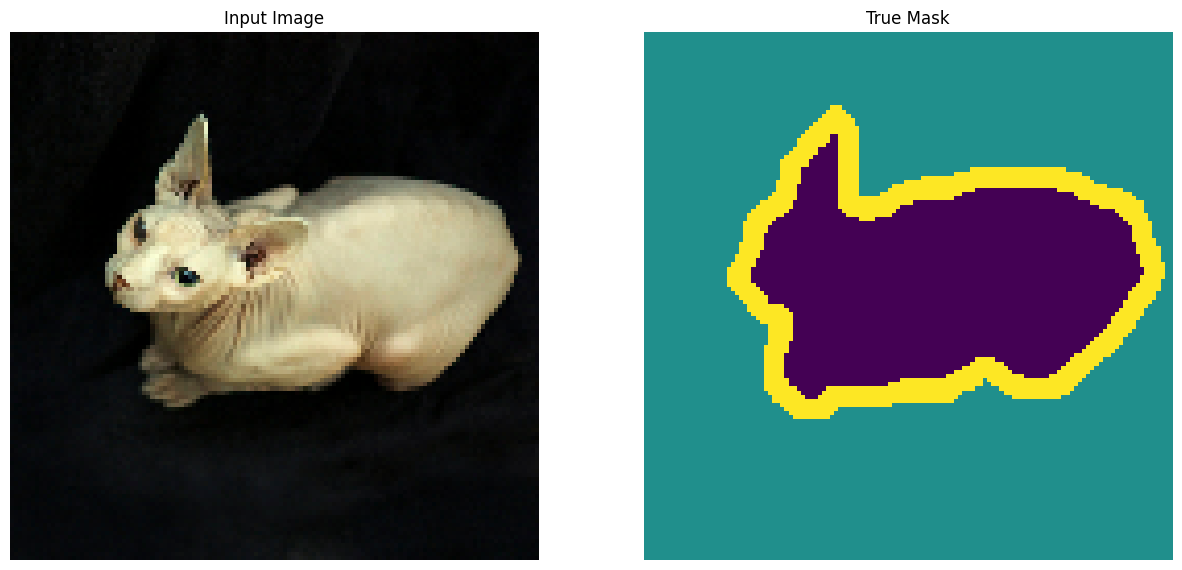

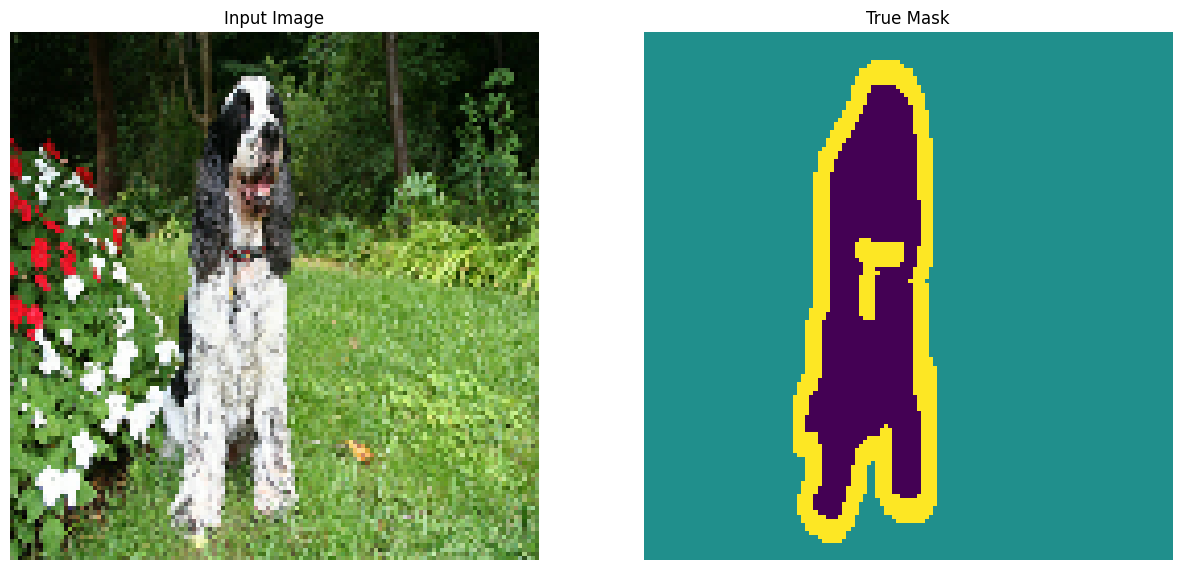

In [26]:
# Plot some of the images
for image, mask in train_images.take(2):
  sample_image, sample_mask = image, mask

  fig = plt.figure(figsize=(15, 15))
  plt.subplot(121)
  plt.title('Input Image')
  plt.imshow(tf.keras.utils.array_to_img(sample_image))
  plt.axis('off')
  plt.subplot(122)
  plt.title('True Mask')
  plt.imshow(tf.keras.utils.array_to_img(sample_mask))
  plt.axis('off')
  plt.show()

In [27]:
# This defines a slight variation of the U-net architecture, replacing
# max-pooling with strided convolutions
def unet(input_shape=(128, 128, 3), num_classes=3):

  inputs = tf.keras.layers.Input(input_shape)

  ######### Encoder

  conv1 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
  conv1 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(conv1)
  conv1_strides = tf.keras.layers.Conv2D(16, 3, strides=2, activation='relu', padding='same')(conv1)
  # Output shape: 64x64

  conv2 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(conv1_strides)
  conv2 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(conv2)
  conv2_strides = tf.keras.layers.Conv2D(32, 3, strides=2, activation='relu', padding='same')(conv2)
  # Output shape: 32x32

  conv3 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv2_strides)
  conv3 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv3)
  conv3_strides = tf.keras.layers.Conv2D(64, 3, strides=2, activation='relu', padding='same')(conv3)
  # Output shape: 16x16

  conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv3_strides)
  conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)
  conv4_strides = tf.keras.layers.Conv2D(128, 3, strides=2, activation='relu', padding='same')(conv4)
  drop4 = tf.keras.layers.Dropout(0.5)(conv4_strides)
  # Output shape: 8x8

  ######## Bottleneck
  conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(drop4)
  conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)
  drop5 = tf.keras.layers.Dropout(0.5)(conv5)
  # Output shape: 8x8

  ######## Decoder

  up6 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(drop5)
  # Output shape: 16x16
  merge6 = tf.keras.layers.concatenate([conv4, up6], axis=3)
  conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge6)
  conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

  up7 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
  # Output shape: 32x32
  merge7 = tf.keras.layers.concatenate([conv3, up7], axis=3)
  conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge7)
  conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

  up8 = tf.keras.layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv7)
  # Output shape: 64x64
  merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
  conv8 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(merge8)
  conv8 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(conv8)

  up9 = tf.keras.layers.Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(conv8)
  # output shape: 128x128
  merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)
  conv9 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(merge9)
  conv9 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(conv9)

  # Output layer
  conv9 = tf.keras.layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(conv9)

  model = tf.keras.Model(inputs=inputs, outputs=conv9)

  return model

# Example usage
model = unet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 128, 128, 16)   │            448 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 64, 64, 16)     │          2,320 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 64, 64, 32)     │          4,640 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ conv2d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ conv2d_28[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ conv2d_29[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 16, 16, 64)     │         36,928 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ conv2d_31[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 8, 8, 128)      │        147,584 │ conv2d_33[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 8, 8, 128)      │              0 │ conv2d_34[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 8, 8, 256)      │        295,168 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 8, 8, 256)      │        590,080 │ conv2d_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 8, 8, 256)      │              0 │ conv2d_36[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 16, 16, 128)    │        131,200 │ dropout_3[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4        

 Total params: 2,137,603 (8.15 MB)

 Trainable params: 2,137,603 (8.15 MB)

 Non-trainable params: 0 (0.00 B)

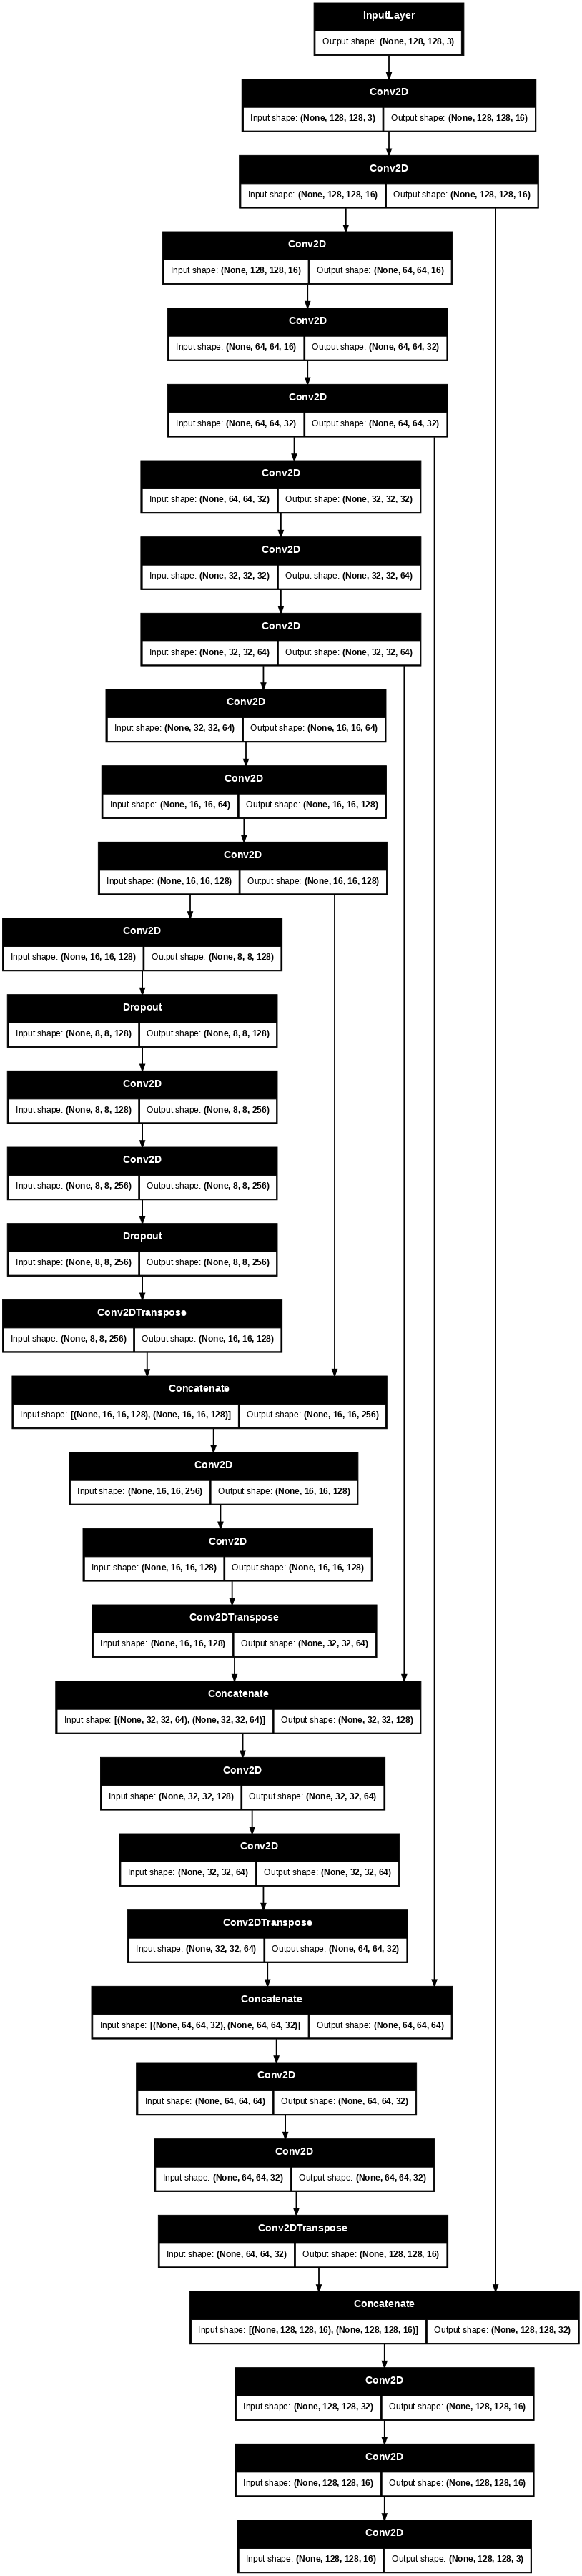

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [30]:
# Plotting routine for the model's prediction
def create_mask(predicted_mask):
  mask = tf.math.argmax(predicted_mask, axis=-1)
  mask = mask[..., tf.newaxis]
  return mask[0]

In [31]:
def plot_predictions(dataset, num=1):

  for image, mask in dataset.take(num):
    pred_mask = model.predict(image)

    plt.figure(figsize=(15, 15))
    plt.subplot(131)
    plt.title('Input Image')
    plt.imshow(tf.keras.utils.array_to_img(image[0]))
    plt.axis('off')

    plt.subplot(132)
    plt.title('True Mask')
    plt.imshow(tf.keras.utils.array_to_img(mask[0]))
    plt.axis('off')

    plt.subplot(133)
    plt.title('Predicted Mask')
    plt.imshow(tf.keras.utils.array_to_img(create_mask(pred_mask)))
    plt.axis('off')

    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


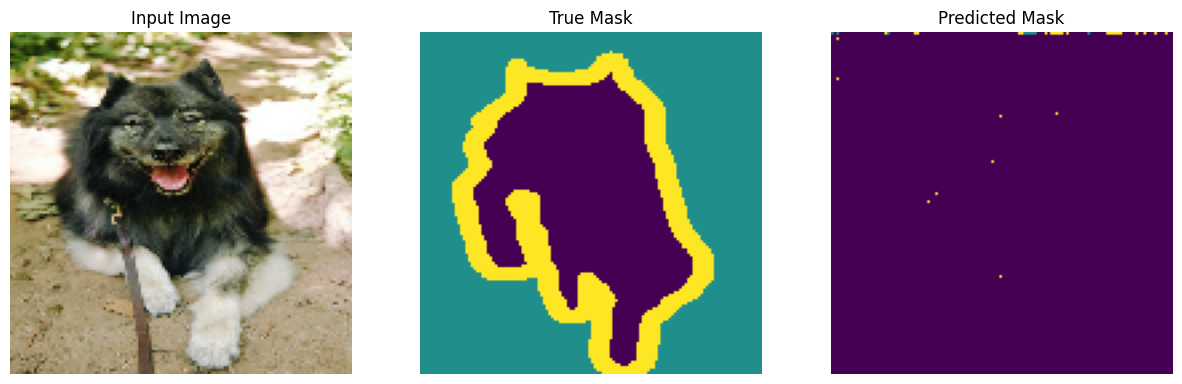

In [32]:
# This is how the results look before training the model
plot_predictions(train_batches, 1)

In [33]:
# Now train the model
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 218ms/step - accuracy: 0.5135 - loss: 1.0097 - val_accuracy: 0.5733 - val_loss: 0.8896
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - accuracy: 0.6360 - loss: 0.8312 - val_accuracy: 0.7027 - val_loss: 0.7345
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.7048 - loss: 0.7284 - val_accuracy: 0.7208 - val_loss: 0.7002
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.7261 - loss: 0.6855 - val_accuracy: 0.7286 - val_loss: 0.6689
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.7361 - loss: 0.6560 - val_accuracy: 0.7548 - val_loss: 0.6074
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.7621 - loss: 0.5942 - val_accuracy: 0.7562 - val_loss: 0.6069
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.7659 - loss: 0.5897 - val_accuracy: 0.7852 - val_loss: 0.5404
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.7850 - loss: 0.5399 - val_accu

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


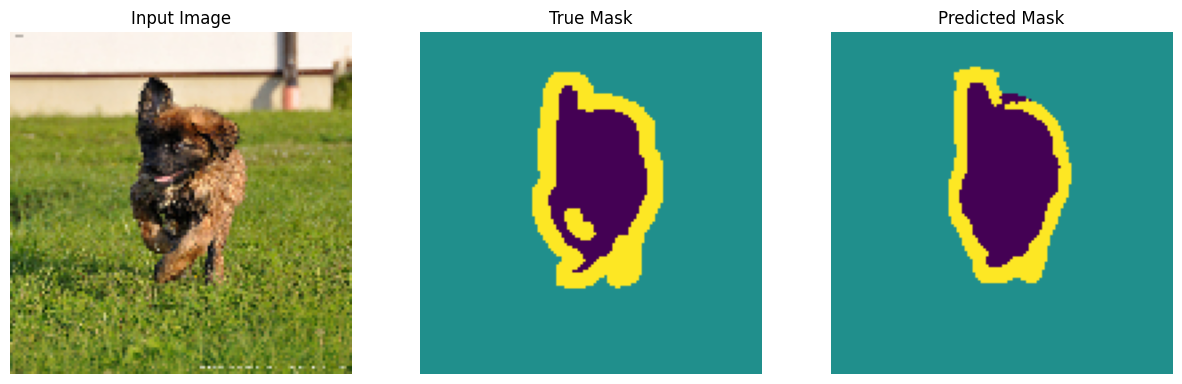

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


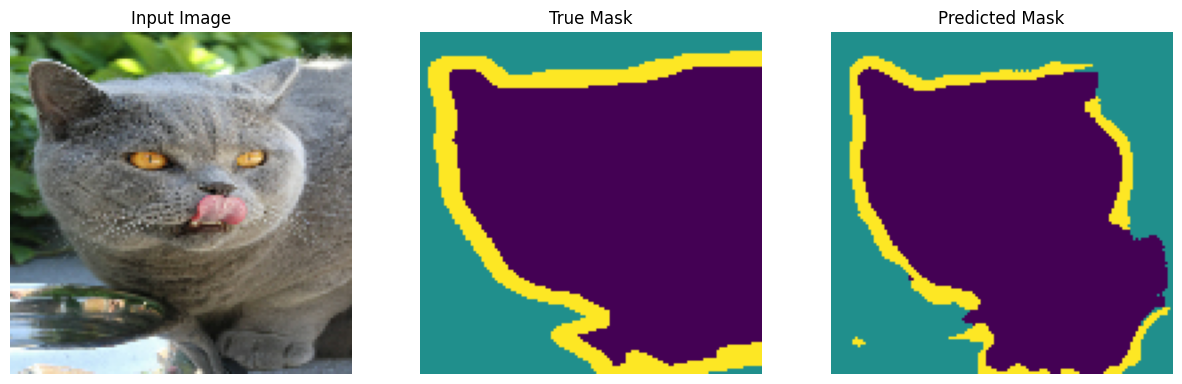

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


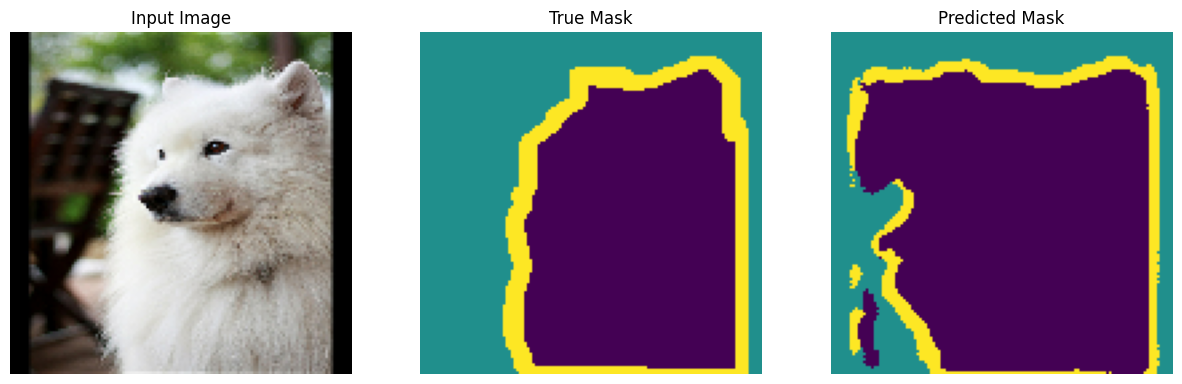

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


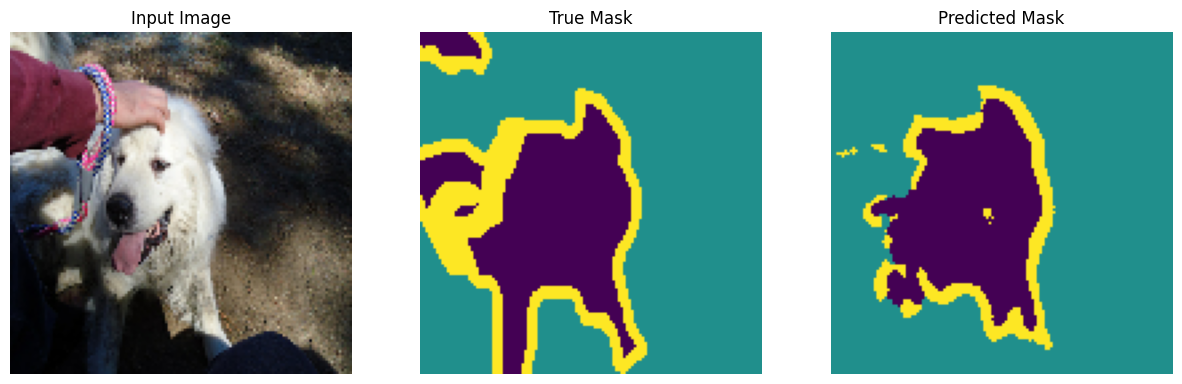

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


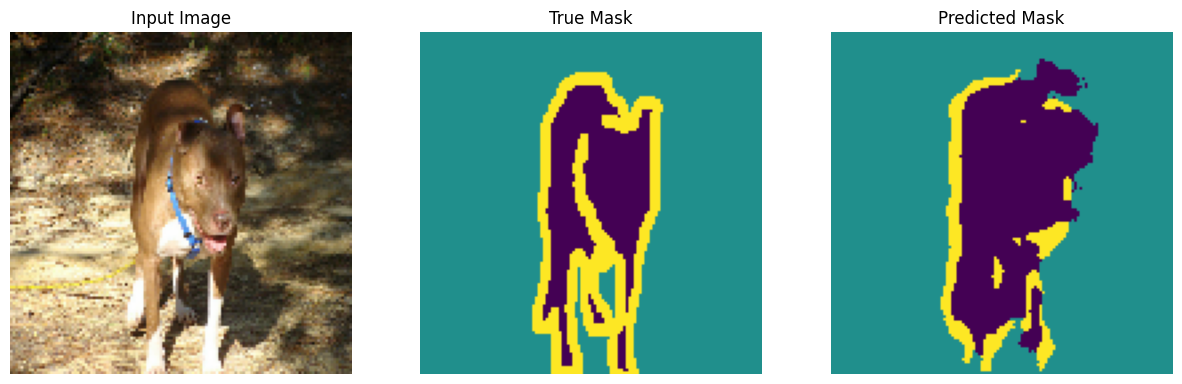

In [35]:
# This is how the results look after training the model
plot_predictions(test_batches, 5)